# I. Select data inside ellipse

> Francisco Carrasco Varela - Pontificia Universidad Católica de Chile (PUC) - ffcarrasco@uc.cl ⭐

<center>
<mark>The following Jupyter Notebook is used to extract and work with Gaia DR3 data<br>
    (and other data releases) </mark>
</center>

Please read carefully the text above each cell before executing it.

In this part of the project we want the following:
- Use the data available to create a Vector Point Diagram (VPD). Basically a proper motion in RA vs. proper motion in DEC plot.

- Using data from [Harris Catalogue (2010)](https://physics.mcmaster.ca/~harris/mwgc.dat), [Baumgardt  et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.5138B/abstract) and [Vasiliev (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.2832V/abstract) locate the center of the expected object in the VPD (if available). If the object is not available into the data given by the authors previously mentioned, the user will have to add the coordinates manually.

- Varying the angle inclination (with respect to x-axis) and the size of the ellipse (in semi-minor and major axis) we will try to maximize the number of stars inside of the ellipse.

- Once the parameters that maximize the number of stars inside the ellipse are found, we use those values to create the 'optimal' ellipse.

- We save the data (stars) that lies into the ellipse to use them into the next step of this Notebook.

## 1-. Import data from previous studies

Here we will simply use data saved in files from previous studies such as [Harris Catalogue (2010)](https://physics.mcmaster.ca/~harris/mwgc.dat), [Baumgardt  et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.5138B/abstract) and [Vasiliev (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.2832V/abstract) based on the name of our object.

This will be useful since in VPD we will be able to locate the mean proper motion coordinates to locate the center of the ellipse.

If for some reason the object is not found, into the next cell (step/section 2 in this script) mean proper motion coordinates will have to be added manually.

In [1]:
# Import all the libraries we will need

%matplotlib inline
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
import matplotlib
import numpy as np
import os
from astropy.io import ascii
from astropy.table import vstack, Table
import sys
from dataclass_wizard import JSONWizard
import json
import import_ipynb

import sys
sys.path.insert(0, '../Scripts/')
import Parameters as PR

In [2]:
### This cell gets the properties for OBJ_NAME if it is listed in Vasiliev (2019) file

###################################################
object_name = "NGC104"  # <--- EDITABLE, use the same object name used in Part 1
vasiliev_file = "../ObservedData/Vasiliev_2019_Gaia_parameters.dat"
###################################################


# --------------------------------------- #

data_list = PR.get_GC_params(vasiliev_file)
obj, success = PR.get_selected_GC(object_name, data_list)

if success:
    n_times = 60
    print("Object detected succesfully!")
    print("-"*n_times)
    print(f"Object name: {obj.name}")
    print(f"Mean Proper Motion RA (mas/yr): {obj.pm_RA} +- {obj.err_pm_RA}")
    print(f"Mean Proper Motion DEC (mas/yr): {obj.pm_DEC} +- {obj.err_pm_DEC}")
    print("-"*n_times)

Object detected succesfully!
------------------------------------------------------------
Object name: NGC104
Mean Proper Motion RA (mas/yr): 5.237 +- 0.039
Mean Proper Motion DEC (mas/yr): -2.524 +- 0.039
------------------------------------------------------------


## 2-. Read filtered file from previous step

Now, continuing from the previous step, we will read the previously saved file (where we had a 'Raw' file and a 'Filtered' file). 
Since we are using Astropy it is recommended to use te 'ascii.escv' format since it allows Astropy to read units (if available) in a faster and easier way.

In this case we will open the file located at *./OBJ_NAME/OBJ_NAME_f_data.dat* since it has values/lower errors for our interest that we have previously filtered.

In [3]:
def check_if_file_exists(filename_path: str) -> None:
    """
    Checks if a file with filtered data that should have been created in the previous step
    of this Notebook is created. If it is not created it will exit the program.
    """
    isExist = os.path.exists(filename_path)
    if not isExist:
        print("You must fully run the previous step in this Notebook and create a file with ", end='')
        print("filtered data before running this cell.")
        sys.exit("Create filtered file in previous step and retry.")
    return


filename_filtered_path = f"../Objects/{object_name.upper()}/1_{object_name.upper()}_f_data.dat"

# Check if the filtered file created in the previous step of thi Notebook exists
check_if_file_exists(filename_filtered_path)

gaia_data = Table.read(filename_filtered_path, format='ascii.ecsv') # get data from previous Notebook step
print('Data read sucessfully')

Data read sucessfully


## 3-. Define the ellipse

Once the data has been read we will apply the following idea to the ellipse:

- Draw an elipse in the VPD.
- If the point (star) is inside the ellipse, add +1 to a counter that counts stars inside ellipse.
- If the point is outside the ellipse, add +1 to a counter that counts stars outside ellipse.
- Get the parameters that maximize the number of stars inside the ellipse.
- Once those parameters are found, use them to create the 'optimized' ellipse and save data inside it for the next step.

In [4]:
# In this cell we will simply define some classes that we will use in the next
# cell. Since the next cell takes its time to run, it is better to define them
# in this place

json_path_file = '../ObservedData/observed_GC_parameters.json'

@dataclass(order=True, kw_only=True)
class EllipseClass():
    """
    A class parameters of an ellipse (adapted to purposes of this code)
    """
    center_x: float # x-axis center coordinate
    center_y: float # y-axis center coordinate
    width: float # in mas / yr
    height: float # in mas / yr
    inclination: float # angle inclination in degrees


@dataclass(frozen=True, order=True, kw_only=True)
class IteratorClass():
    """
    A class used to change iterators cycles/parameters
    """
    minimum: float
    maximum: float
    n_step: int
        
def getValuesByObjName(obj_name: str, filename_json: str) -> (IteratorClass, 
                                                              IteratorClass, 
                                                              IteratorClass):
    """
    Values that I have found for every object name that fits better for the ellipse.
    These are the values used by me (F. Carrasco) if I do not want to re-run the
    Montecarlo loop.
    """
    
    # Read JSON file
    with open(filename_json, 'r') as j:
        data_json = json.loads(j.read())
    
    # Load JSON data (dictionary) into our custom class
    object_json = PR.ParametersList.from_dict(data_json)
    
    # Check value for previously studied object
    for item in object_json.globular_cluster:
        if item.name.upper() == obj_name.upper():
            cluster_found = PR.ParametersGC(name=item.name, 
                                         PM_plot_x_axis_min=float(item.PM_plot_x_axis_min),
                                         PM_plot_x_axis_max=float(item.PM_plot_x_axis_max),
                                         PM_plot_y_axis_min=float(item.PM_plot_y_axis_min),
                                         PM_plot_y_axis_max=float(item.PM_plot_y_axis_max),
                                         width_minim=float(item.width_minim),
                                         width_maxim=float(item.width_maxim),
                                         width_nstep=int(item.width_nstep),
                                         height_minim=float(item.height_minim),
                                         height_maxim=float(item.height_maxim),
                                         height_nstep=int(item.height_nstep),
                                         incl_minim=float(item.incl_minim),
                                         incl_maxim=float(item.incl_maxim),
                                         incl_nstep=int(item.incl_nstep))
            break
            
    width_min = cluster_found.width_minim 
    width_max = cluster_found.width_maxim
    width_nsteps = cluster_found.width_nstep
    
    height_min = cluster_found.height_minim
    height_max = cluster_found.height_maxim
    height_nsteps = cluster_found.height_nstep
    
    incl_min = cluster_found.incl_minim
    incl_max = cluster_found.incl_maxim
    incl_nsteps = cluster_found.incl_nstep
        
    # Return values into a custom class
    width_it = IteratorClass(minimum=width_min, maximum=width_max, n_step=width_nsteps)
    height_it = IteratorClass(minimum=height_min, maximum=height_max, n_step=height_nsteps)
    angle_incl_it = IteratorClass(minimum=incl_min, maximum=incl_max, n_step=incl_nsteps)
    
    return width_it, height_it, angle_incl_it       

You may want to edit some values in the next cell... (look for `*# <--- EDITABLE*` in code line)

If you want to re-use parameters that you have previously used, change variable `usePreviouslyFoundValues=False` to `usePreviouslyFoundValues=True`.

In [5]:
# This cell is a Montecarlo selection, go for a coffee.
# It will take some time...

usePreviouslyFoundValues = True # use values previously found contained in JSON file

def checkIfMax(value: int, current_max: int) -> (int, bool):
    """
    Simple function that checks if a value is bigger than a current one.
    If the value is greater than the current maximum, it returns the value.
    Otherwise it returns the maximum.
    """
    if value > current_max:
        return value, True
    return current_max, False


def DefineEllipse(x: np.ndarray, y: np.ndarray, x_center: float, y_center: float, 
                  ell_width: float, ell_height: float, angle_inclination: float, 
                  ) -> np.ndarray:
    """
    Create an ellipse with center given with coordinates (x_center, y_center).
    Also, a width and height (x and y-axis, respectively) must be passed, given
    an 'incilnation' angle.
    """
    
    cos_angle = np.cos(np.radians(180.-angle_inclination))
    sin_angle = np.sin(np.radians(180.-angle_inclination))

    xc = x - x_center
    yc = y - y_center

    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle 

    rad_cc = (xct**2/(ell_width/2.)**2) + (yct**2/(ell_height/2.)**2)
    return rad_cc


def loop_Montecarlo(x: np.ndarray, y: np.ndarray, pmRA: float, pmDEC: float,
                   w_array: np.ndarray, h_array: np.ndarray, a_array: np.ndarray
                   ) -> EllipseClass:
    max_in_stars = 0
    ellipse_parameters = EllipseClass(center_x=0., center_y=0, width=0., height=0., inclination=0.)
    for w_it in w_array:
        for h_it in h_array:
            for angle_it in a_array:
                if w_it == h_it:
                    continue # due to tidal forces, object in VPD will have an elliptic form
                             # also, applying an inclination to a circle is not very useful...
                counter_in, counter_out = 0, 0
                ellipse_zone = DefineEllipse(x, y, obj.pm_RA, obj.pm_DEC, w_it, h_it, angle_it)
                for r in ellipse_zone:
                    if r <= 1:
                        counter_in += 1
                    if r > 1:
                        counter_out += 1
                max_in_stars, save_parameters = checkIfMax(counter_in, max_in_stars)
                if save_parameters:
                    ellipse_parameters = EllipseClass(center_x=obj.pm_RA, center_y=obj.pm_DEC, width=w_it,
                                                     height=h_it, inclination=angle_it)
    return ellipse_parameters
    

def countStarsInsideEllipse(obj: PR.VasilievData, gaiaData: Table, usePrevValues: bool,
                           json_filename: str) -> EllipseClass:
    """
    A simple function that count stars inside an ellipse. It will return an Ellipse
    object with parameters that maximizes the numbers of stars/objects within an
    ellipse in a Vector Point Diagram; where the ellipse center will be given by
    parameters given in Vasiliev (2019) file (if available).
    """
    inside_stars, outside_stars = 0, 0
    
    # Create a copy of the arrays containing positions (x,y) in VPD
    x, y = np.asarray(gaiaData['pmra']), np.asarray(gaiaData['pmdec'])
        
    ### If the user wants to use previously used values...
    if usePrevValues and (obj.name.upper() in [name_it.name.upper() for name_it in data_list.data]):
        print(f"Using previously found/saved values for {obj.name.upper()!r}...\n\n")
        width_it, height_it, angle_incl_it = getValuesByObjName(obj.name, json_filename)
        width_range = np.linspace(width_it.minimum, width_it.maximum, width_it.n_step)
        height_range = np.linspace(height_it.minimum, height_it.maximum, height_it.n_step)
        angle_range = np.linspace(angle_incl_it.minimum, angle_incl_it.maximum, 
                                  angle_incl_it.n_step)
        optimal_ellipse = loop_Montecarlo(x, y, obj.pm_RA, obj.pm_DEC, width_range, 
                                          height_range, angle_range)
        return optimal_ellipse
      
    ### If the user does not want to use previously used values, use your own
    # Parameters for ellipse width
    width_min, width_max, width_nsteps = 1.65, 1.7, 2 # in mas / yr <---------EDITABLE
    width_it = IteratorClass(minimum=width_min, maximum=width_max, n_step=width_nsteps)

    # Parameters for ellipse height
    height_min, height_max, height_nsteps = 1.85, 1.9, 2 # in mas / yr <---------EDITABLE
    height_it = IteratorClass(minimum=height_min, maximum=height_max, n_step=height_nsteps)
    
    # Parameters for ellipse inclination
    incl_min, incl_max, incl_nsteps = -89.9, 89.9, 200 # in degrees <---------EDITABLE
    angle_incl_it = IteratorClass(minimum=incl_min, maximum=incl_max, n_step=incl_nsteps)
    
    width_range = np.linspace(width_it.minimum, width_it.maximum, width_it.n_step)
    height_range = np.linspace(height_it.minimum, height_it.maximum, height_it.n_step)
    angle_range = np.linspace(angle_incl_it.minimum, angle_incl_it.maximum, angle_incl_it.n_step)

    optimal_ellipse = loop_Montecarlo(x, y, obj.pm_RA, obj.pm_DEC, width_range, height_range,
                                     angle_range)
    return optimal_ellipse
 
# ----------------------------------------------
    
ellipse = countStarsInsideEllipse(obj, gaia_data, usePreviouslyFoundValues, 
                                  json_path_file)
print("\"Optimized\" ellipse parameters:")
print(f"-> Center coordinates in VPD: ({ellipse.center_x:.2f}, {ellipse.center_y:.2f})")
print(f"-> Width: {ellipse.width:.2f} mas / yr\n-> Height: {ellipse.height:.2f} mas / yr")
print(f"-> Angle inclination: {ellipse.inclination:.2f} deg")


Using previously found/saved values for 'NGC104'...


"Optimized" ellipse parameters:
-> Center coordinates in VPD: (5.24, -2.52)
-> Width: 1.70 mas / yr
-> Height: 1.90 mas / yr
-> Angle inclination: -54.66 deg


## 4-. Select data that lies inside the ellipse

Now that we have found the optimal ellipse we simply apply it to the original data and keep all data inside it. It is also recommended to plot the result.

In [6]:
def classifyData(gaiaData: Table, ell: EllipseClass
                ) -> (np.ndarray, list[str]):
    """
    Given a data with parameters/coordinates (x,y), if the data is inside the ellipse 
    (ell) we keep it. Else, it is discarded. This function returns a boolean list 
    that will be used to mask data and a list with colors to plot.
    """
    x, y = np.asarray(gaiaData['pmra']), np.asarray(gaiaData['pmdec'])
    rad_cc = DefineEllipse(x, y, ell.center_x, ell.center_y, ell.width, 
                           ell.height, ell.inclination)

    mask_array, color_array = [], []
    for r in rad_cc:
        if r <= 1:
            mask_array.append(True)
            color_array.append('green')
        if r > 1:
            mask_array.append(False)
            color_array.append('black')
    
    if (len(x) != len(mask_array)) or (len(y) != len(mask_array)):
        assert False, "Mask length invalid"
    mask_array = np.asarray(mask_array)
    
    return mask_array, color_array
        
# Create mask to filter data
r_mask, colors_array = classifyData(gaia_data, ellipse)
filtered_data = gaia_data[r_mask]

# Results after filtering data
original_length, filtered_length = len(gaia_data['pmra']), len(filtered_data['pmra'])
print(f"Data before filter: {original_length}\nData after filter: {filtered_length}")
print(f"Percentage filtered data: {round(100*(original_length - filtered_length)/original_length,2)}%")


Data before filter: 47361
Data after filter: 38566
Percentage filtered data: 18.57%


Before saving data that lies inside the ellipse, make a plot to ensure the result is what you desire. If it is not, you can simply change values into the cell where we select the 'optimal' ellipse.

NGC104 object found in JSON file!
Using parameters X:[-2.0, 10.0], Y: [-8.0, 4.0]


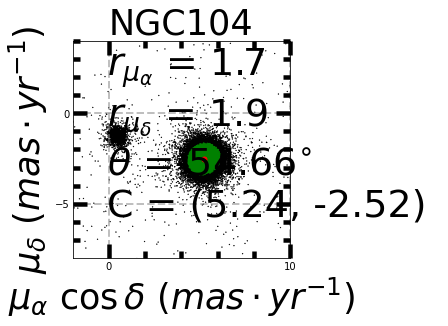

In [7]:
### Plotting time!!!
# P.S.: You should run this cell twice to apply changes in plot

usePreviousValues = True # Set to 'False' if you do not want to use pre-set values

parameters, isInJSONfile = PR.isInJSONParametersFile(json_path_file, object_name)

if usePreviousValues and isInJSONfile:
    print(f'{object_name} object found in JSON file!')
    x_limit = [parameters.PM_plot_x_axis_min, parameters.PM_plot_x_axis_max]
    y_limit = [parameters.PM_plot_y_axis_min, parameters.PM_plot_y_axis_max]
    print(f'Using parameters X:{x_limit}, Y: {y_limit}')

else: # choose your custom values to plot here
    print('Using custom values for X and Y limits in plot')
    x_limit = [-2., 10.]
    y_limit = [-8, 4.]
    

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

label_fontsize = 35
ax.set_xlim(x_limit[0], x_limit[1])
ax.set_ylim(y_limit[0], y_limit[1])
plt.rcParams["figure.figsize"] = (28,21)
matplotlib.rc('xtick', labelsize=32) 
matplotlib.rc('ytick', labelsize=32)

plt.rcParams["figure.figsize"] = (28,21)
ellipse_center = (ellipse.center_x, ellipse.center_y)
g_ellipse = patches.Ellipse(ellipse_center, ellipse.width, ellipse.height, 
                            angle=ellipse.inclination, fill=False, 
                            edgecolor='green', linewidth=0.3)
ax.add_patch(g_ellipse)
ax.scatter(gaia_data['pmra'], gaia_data['pmdec'], c=colors_array, linewidths=0.3, s=1.)
ax.plot(obj.pm_RA, obj.pm_DEC, 'ro', markersize = 5, label = 'Vasiliev (2019) center')
anchored_text = AnchoredText(r'$r_{\mu_\alpha}$ = '+str(round(ellipse.width,1))+'\n'
                             +r'$r_{\mu_\delta}$ = '+str(round(ellipse.height,1))+'\n'
                             +r'$\theta $ ='+str(round(ellipse.inclination,2))
                             +r'$^{\circ}$'
                             +'\nC = ('+str(round(obj.pm_RA,2))+', ' +str(round(obj.pm_DEC,2))+')', 
                             loc='lower left', frameon=False,
                             prop=dict(size=38))
ax.add_artist(anchored_text)
ax.grid(color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.set(xlabel=r'$\mu_{\alpha} \ \cos \delta$ ($mas \cdot yr^{-1}$)', 
       ylabel="$\mu_{\delta}$ ($mas \cdot yr^{-1}$)")
ax.xaxis.label.set_size(label_fontsize)
ax.yaxis.label.set_size(label_fontsize)
ax.tick_params(which='both', width=4.5, top='on')
ticksize = 14
ax.tick_params(which='major',length=ticksize, direction = 'in')
ax.tick_params(which='minor',length=ticksize/2., direction = 'in')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.title(object_name.upper(), fontsize=35)
plt.show()

## 5-. Save data inside ellipse

- Finally, we can just save the data that is inside the ellipse in Table format used by Astropy. Similar as saved into the previous step of this Notebook, we now save files with name *2_OBJ_NAME_f_data.dat* (filtered data), where *OBJ_NAME* will be replaced with the name of your object in upper case letters, and '2' represents this data wa produced into the first step of this Notebook. We do not save data that was not filtered since it is the same data as the filtered data from the previous step. 

- As in the previous step, this will be saved into *./Objects/OBJ_NAME* directory (that should have been created in the previous step if it did not exist. Read section 4 from the previous step/notebook for more information).

In [9]:
dir_path = f"../Objects/{obj.name.upper()}/"
save_filename = f"2_{obj.name.upper()}_f_data.dat"

filtered_data.write(f"{dir_path}{save_filename}", format='ascii.ecsv', overwrite=True)
print('Done!')

Done!


You are ready to go to the next step! 🤓